In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize, LinearConstraint, fsolve
from scipy.stats import norm

In [ ]:
URL = 'https://github.com/HarrisonLam129/PM/raw/refs/heads/main/df'
dfs = []
for i in range(1, 6):
    dfs.append(pd.read_pickle(URL+str(i)))
df1, df2, df3, df4, df5 = dfs

### Model 1 (Equal weighted)

In [ ]:
sharpes = pd.DataFrame(dict(zip([f'df{i}' for i in range(1, 6)], [[] for _ in range(5)])))
sharpes_p = pd.DataFrame(dict(zip([f'df{i}' for i in range(1, 6)], [[] for _ in range(5)])))
CEQ = pd.DataFrame(dict(zip([f'df{i}' for i in range(1, 6)], [[] for _ in range(5)])))
CEQ_p = pd.DataFrame(dict(zip([f'df{i}' for i in range(1, 6)], [[] for _ in range(5)])))
turnover = pd.DataFrame(dict(zip([f'df{i}' for i in range(1, 6)], [[] for _ in range(5)])))

gamma = 1

returns1 = df1.mean(axis=1)
returns2 = pd.concat([df.mean(axis=1) for df in dfs[1:]], axis=1)

ew_mean = np.hstack((returns1[120:].mean(), returns2[120:].mean()))
ew_std = np.hstack((returns1[120:].std(ddof=1), returns2[120:].std(ddof=1)))

sharpes.loc['1/N In'] = np.hstack(([returns1.mean()/returns1.std(ddof=1)], (returns2.mean()/returns2.std(ddof=1)).values))
sharpes_p.loc['1/N In'] = np.array([np.NaN]*5)
CEQ.loc['1/N In'] = np.hstack(([returns1.mean()-(gamma/2)*returns1.std(ddof=1)**2], (returns2.mean()-(gamma/2)*returns2.std(ddof=1)**2).values))
CEQ_p.loc['1/N In'] = np.array([np.NaN]*5)

M = 120

turnovers = []
for df in dfs:
    weights = (1/len(df.columns)) * np.ones((len(df)-M, len(df.columns)))
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights_before.div(np.abs(weights_before.sum(axis=1)), axis=0)
    turnovers.append((weights_before-weights).abs().sum().sum()/(len(df)-M))
turnover.loc['1/N In'] = np.array(turnovers)

### Model 2 (mean-variance)


In [ ]:
sr = []
ceq = []
for df in dfs:
    mu = df.mean(axis = 0)
    cov = df.cov()
    x = np.linalg.inv(cov)@mu
    w = x / np.abs(x.sum())
    sr.append((mu @ w) / np.sqrt(w.T @ cov @ w))
    ceq.append((mu @ w) - (gamma/2)*(w.T @ cov @ w))

sharpes.loc['mv In'] = sr
CEQ.loc['mv In'] = ceq

sr, sr_p = [], []
mus, sigmas, sigma_i_ns, len_r = [], [], [], []
ceq, CEQ_z = [], []
turnovers = []
m1, m2 = float('inf'), -float('inf')
for j, df in enumerate(dfs):
    weights = []
    r = []
    for i in range(M, len(df)):
        mu_t = df.iloc[i-M:i].mean(axis = 0)
        cov_t = df.iloc[i-M:i].cov()
        x_t = np.linalg.inv(cov_t)@mu_t
        w_t = x_t / np.abs(np.sum(x_t))
        weights.append(w_t)
        r_t = w_t.T @ df.iloc[i]
        r.append(r_t)
    mus.append(np.mean(r))
    sigmas.append(np.std(r, ddof=1))
    if j == 0:
        sigma_i_n = np.cov(r, returns1[120:])[0, 1]
    else:
        sigma_i_n = np.cov(r, returns2.iloc[120:, j-1])[0, 1]
    sigma_i_ns.append(sigma_i_n)
    len_r.append(len(r))
    sr.append(np.mean(r)/np.std(r, ddof=1))
    ceq.append(np.mean(r) - (gamma/2)*np.std(r, ddof=1)**2)

    CEQ_diff = np.mean(r) - (gamma/2)*np.std(r, ddof=1)**2 - CEQ.loc['1/N In', f'df{j+1}']
    grad = np.array([1, -1, -gamma/2, gamma/2])
    theta = np.array([[np.std(r, ddof=1)**2, sigma_i_n, 0, 0], [sigma_i_n, ew_std[j]**2, 0, 0], [0, 0, 2*np.std(r, ddof=1)**4, 2*sigma_i_n**2], [0, 0, 2*sigma_i_n**2, 2*ew_std[j]**4]])
    CEQ_z.append(np.sqrt(len(df))*CEQ_diff/np.sqrt(grad.T @ theta @ grad))

    weights = np.array(weights)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights_before.div(np.abs(weights_before.sum(axis=1)), axis=0)
    turnovers.append((weights_before-weights).abs().sum().sum()/(len(r)))
    m1 = min(m1, weights.min())
    m2 = max(m2, weights.max())

print(m1, m2)
sharpes.loc['mv Out'] = sr
mus, sigmas, sigma_i_ns, len_r = np.array(mus), np.array(sigmas), np.array(sigma_i_ns), np.array(len_r)
nu = (1/len_r)*(2*sigmas**2*ew_std**2 - 2*sigmas*ew_std*sigma_i_ns + 0.5*mus**2*ew_std**2 + \
                    0.5*ew_mean**2*sigmas**2 - mus*ew_mean*sigma_i_ns**2/(ew_std*sigmas))
z_scores = (ew_std*mus-sigmas*ew_mean)/np.sqrt(nu)
sharpes_p.loc['mv Out'] = 1-norm.cdf(z_scores)

CEQ.loc['mv Out'] = ceq
CEQ_p.loc['mv Out'] = 1-norm.cdf(CEQ_z)

turnover.loc['mv Out'] = np.array(turnovers)

-13886.76007997952 6678.915013684866


### Model 3 (min-variance)

In [ ]:
"""
sr = []
ceq = []
for df in dfs:
    cov = df.cov()
    x = np.linalg.inv(cov).sum(axis=1)
    w = x / x.sum()
    mu = df.mean(axis = 0)
    sr.append(mu @ w / np.sqrt(w.T @ cov @ w))
    ceq.append((mu @ w) - (gamma/2)*(w.T @ cov @ w))
sharpes.loc['min In'] = sr
CEQ.loc['min In'] = ceq
"""

sr, sr_p = [], []
mus, sigmas, sigma_i_ns = [], [], []
ceq, CEQ_z = [], []
turnovers = []
m1, m2 = float('inf'), -float('inf')
for j, df in enumerate(dfs):
    weights = []
    r = []
    for i in range(M, len(df)):
        cov_t = df.iloc[i-M: i].cov()
        x_t = np.linalg.inv(cov_t).sum(axis=1)
        w_t = x_t / x_t.sum()
        weights.append(w_t)
        r_t = w_t.T @ df.iloc[i]
        r.append(r_t)
    mus.append(np.mean(r))
    sigmas.append(np.std(r, ddof=1))
    if j == 0:
        sigma_i_n = np.cov(r, returns1[120:])[0, 1]
    else:
        sigma_i_n = np.cov(r, returns2.iloc[120:, j-1])[0, 1]
    sigma_i_ns.append(sigma_i_n)
    sr.append(np.mean(r)/np.std(r, ddof=1))
    ceq.append(np.mean(r)-(gamma/2)*np.std(r, ddof=1)**2)

    CEQ_diff = np.mean(r) - (gamma/2)*np.std(r, ddof=1)**2 - CEQ.loc['1/N In', f'df{j+1}']
    grad = np.array([1, -1, -gamma/2, gamma/2])
    theta = np.array([[np.std(r, ddof=1)**2, sigma_i_n, 0, 0], [sigma_i_n, ew_std[j]**2, 0, 0], [0, 0, 2*np.std(r, ddof=1)**4, 2*sigma_i_n**2], [0, 0, 2*sigma_i_n**2, 2*ew_std[j]**4]])
    CEQ_z.append(np.sqrt(len(df))*CEQ_diff/np.sqrt(grad.T @ theta @ grad))

    weights = np.array(weights)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights_before.div(np.abs(weights_before.sum(axis=1)), axis=0)
    turnovers.append((weights_before-weights).abs().sum().sum()/(len(r)))
    m1 = min(m1, weights.min())
    m2 = max(m2, weights.max())

print(m1, m2)
sharpes.loc['min Out'] = sr
mus, sigmas, sigma_i_ns = np.array(mus), np.array(sigmas), np.array(sigma_i_ns)
nu = (1/len_r)*(2*sigmas**2*ew_std**2 - 2*sigmas*ew_std*sigma_i_ns + 0.5*mus**2*ew_std**2 + \
                    0.5*ew_mean**2*sigmas**2 - mus*ew_mean*sigma_i_ns**2/(ew_std*sigmas))
z_scores = (ew_std*mus-sigmas*ew_mean)/np.sqrt(nu)
sharpes_p.loc['min Out'] = 1-norm.cdf(z_scores)

CEQ.loc['min Out'] = ceq
CEQ_p.loc['min Out'] = 1-norm.cdf(CEQ_z)

turnover.loc['min Out'] = np.array(turnovers)

-5.650920374903726 2.278745188405432


### Bayes Stein

In [ ]:
sr, sr_p = [], []
mus, sigmas, sigma_i_ns = [], [], []
ceq, CEQ_z = [], []
turnovers = []

for j, df in enumerate(dfs):
    weights = []
    N = df.shape[1]
    r = []
    for t in range(M, len(df)):
        window = df.iloc[t-M:t]

        cov_t = window.cov(ddof=N+2)

        inv_cov_t = np.linalg.inv(cov_t)

        ones = np.ones(N)
        w_min = inv_cov_t @ ones / (ones.T @ inv_cov_t @ ones)

        mu_t = window.mean(axis=0)

        # Mean return of min-var
        mu_min_t = w_min.T @ mu_t

        diff = mu_t - mu_min_t
        phi_t = (N + 2) / ((N + 2) + M * diff.T @ inv_cov_t @ diff) # Shrinkage factor

        # Bayes-Stein mean
        mu_bs_t_vector = (1 - phi_t) * mu_t + phi_t * mu_min_t  # Vector

        w_t = (inv_cov_t @ mu_bs_t_vector)/(ones.T @ inv_cov_t @ mu_bs_t_vector)
        weights.append(w_t)
        r_t = w_t @ df.iloc[t]
        r.append(r_t)
    mus.append(np.mean(r))
    sigmas.append(np.std(r, ddof=1))
    if j == 0:
        sigma_i_n = np.cov(r, returns1[120:])[0, 1]
    else:
        sigma_i_n = np.cov(r, returns2.iloc[120:, j-1])[0, 1]
    sigma_i_ns.append(sigma_i_n)
    sr.append(np.mean(r)/np.std(r, ddof=1))
    ceq.append(np.mean(r)-(gamma/2)*np.std(r, ddof=1)**2)

    CEQ_diff = np.mean(r) - (gamma/2)*np.std(r, ddof=1)**2 - CEQ.loc['1/N In', f'df{j+1}']
    grad = np.array([1, -1, -gamma/2, gamma/2])
    theta = np.array([[np.std(r, ddof=1)**2, sigma_i_n, 0, 0], [sigma_i_n, ew_std[j]**2, 0, 0], [0, 0, 2*np.std(r, ddof=1)**4, 2*sigma_i_n**2], [0, 0, 2*sigma_i_n**2, 2*ew_std[j]**4]])
    CEQ_z.append(np.sqrt(len(df))*CEQ_diff/np.sqrt(grad.T @ theta @ grad))

    weights = np.array(weights)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights_before.div(np.abs(weights_before.sum(axis=1)), axis=0)
    turnovers.append((weights_before-weights).abs().sum().sum()/(len(r)))

sharpes.loc['bs'] = sr
mus, sigmas, sigma_i_ns = np.array(mus), np.array(sigmas), np.array(sigma_i_ns)
nu = (1/len_r)*(2*sigmas**2*ew_std**2 - 2*sigmas*ew_std*sigma_i_ns + 0.5*mus**2*ew_std**2 + \
                    0.5*ew_mean**2*sigmas**2 - mus*ew_mean*sigma_i_ns**2/(ew_std*sigmas))
z_scores = (ew_std*mus-sigmas*ew_mean)/np.sqrt(nu)
sharpes_p.loc['bs'] = 1-norm.cdf(z_scores)

CEQ.loc['bs'] = ceq
CEQ_p.loc['bs'] = 1-norm.cdf(CEQ_z)

turnover.loc['bs'] = np.array(turnovers)

### Value-Weighted (Market)

In [ ]:
sr, sr_p = [], []
mus, sigmas, sigma_i_ns = [], [], []
ceq, CEQ_z = [], []

for j, df in enumerate(dfs):
    r = df['MKT'].values
    mus.append(np.mean(r))
    sigmas.append(np.std(r, ddof=1))
    if j == 0:
        sigma_i_n = np.cov(r, returns1)[0, 1]
    else:
        sigma_i_n = np.cov(r, returns2.iloc[:, j-1])[0, 1]
    sigma_i_ns.append(sigma_i_n)
    sr.append(np.mean(r)/np.std(r, ddof=1))
    ceq.append(np.mean(r)-(gamma/2)*np.std(r, ddof=1)**2)

    CEQ_diff = np.mean(r) - (gamma/2)*np.std(r, ddof=1)**2 - CEQ.loc['1/N In', f'df{j+1}']
    grad = np.array([1, -1, -gamma/2, gamma/2])
    theta = np.array([[np.std(r, ddof=1)**2, sigma_i_n, 0, 0], [sigma_i_n, ew_std[j]**2, 0, 0], [0, 0, 2*np.std(r, ddof=1)**4, 2*sigma_i_n**2], [0, 0, 2*sigma_i_n**2, 2*ew_std[j]**4]])
    CEQ_z.append(np.sqrt(len(df))*CEQ_diff/np.sqrt(grad.T @ theta @ grad))

sharpes.loc['vw'] = sr
mus, sigmas, sigma_i_ns = np.array(mus), np.array(sigmas), np.array(sigma_i_ns)
nu = (1/len_r)*(2*sigmas**2*ew_std**2 - 2*sigmas*ew_std*sigma_i_ns + 0.5*mus**2*ew_std**2 + \
                    0.5*ew_mean**2*sigmas**2 - mus*ew_mean*sigma_i_ns**2/(ew_std*sigmas))
z_scores = (ew_std*mus-sigmas*ew_mean)/np.sqrt(nu)
sharpes_p.loc['vw'] = 1-norm.cdf(z_scores)

CEQ.loc['vw'] = ceq
CEQ_p.loc['vw'] = 1-norm.cdf(CEQ_z)

turnover.loc['vw'] = np.array([0, 0, 0, 0, 0])

### No Shortsale MV

In [ ]:
"""
sr, ceq = [], []

for df in dfs:
    x_0 = np.array([1/(df.shape[1])]*df.shape[1])
    mu, cov = df.mean(axis=0), df.cov()
    range_constraint = [[0, np.inf] for _ in range(df.shape[1])]
    mv_c = minimize(lambda x: -(x @ mu - (gamma/2)* x.T @ cov @ x), x_0, bounds=range_constraint)
    w_t = mv_c.x/np.sum(mv_c.x)
    sr.append(mu @ w_t / np.sqrt(w_t.T @ cov @ w_t))
    ceq.append((mu @ w_t) - (gamma/2)*(w_t.T @ cov @ w_t))

sharpes.loc['mv-c In'] = sr
CEQ.loc['mv-c In'] = ceq
"""

sr, sr_p = [], []
mus, sigmas, sigma_i_ns = [], [], []
ceq, CEQ_z = [], []
turnovers = []
for j, df in enumerate(dfs):
    weights = []
    range_constraint = [[0, np.inf] for _ in range(df.shape[1])]
    x_0 = np.array([1/(df.shape[1])]*df.shape[1])
    r = []
    for i in range(M, len(df)):
        mu = df.iloc[i-M:i].mean(axis=0)
        cov = df.iloc[i-M:i].cov()
        mv_c = minimize(lambda x: -(x.T @ mu - (gamma/2)* x.T @ cov @ x), x_0, bounds=range_constraint)
        w_t = mv_c.x/np.sum(mv_c.x)
        weights.append(w_t)
        r_t = w_t.T @ df.iloc[i]
        r.append(r_t)
    mus.append(np.mean(r))
    sigmas.append(np.std(r, ddof=1))
    if j == 0:
        sigma_i_n = np.cov(r, returns1[120:])[0, 1]
    else:
        sigma_i_n = np.cov(r, returns2.iloc[120:, j-1])[0, 1]
    sigma_i_ns.append(sigma_i_n)
    sr.append(np.mean(r)/np.std(r, ddof=1))
    ceq.append(np.mean(r) - (gamma/2)*np.std(r, ddof=1)**2)

    CEQ_diff = np.mean(r) - (gamma/2)*np.std(r, ddof=1)**2 - CEQ.loc['1/N In', f'df{j+1}']
    grad = np.array([1, -1, -gamma/2, gamma/2])
    theta = np.array([[np.std(r, ddof=1)**2, sigma_i_n, 0, 0], [sigma_i_n, ew_std[j]**2, 0, 0], [0, 0, 2*np.std(r, ddof=1)**4, 2*sigma_i_n**2], [0, 0, 2*sigma_i_n**2, 2*ew_std[j]**4]])
    CEQ_z.append(np.sqrt(len(df))*CEQ_diff/np.sqrt(grad.T @ theta @ grad))

    weights = np.array(weights)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights_before.div(np.abs(weights_before.sum(axis=1)), axis=0)
    turnovers.append((weights_before-weights).abs().sum().sum()/(len(r)))

sharpes.loc['mv-c Out'] = sr
mus, sigmas, sigma_i_ns = np.array(mus), np.array(sigmas), np.array(sigma_i_ns)
nu = (1/len_r)*(2*sigmas**2*ew_std**2 - 2*sigmas*ew_std*sigma_i_ns + 0.5*mus**2*ew_std**2 + \
                    0.5*ew_mean**2*sigmas**2 - mus*ew_mean*sigma_i_ns**2/(ew_std*sigmas))
z_scores = (ew_std*mus-sigmas*ew_mean)/np.sqrt(nu)
sharpes_p.loc['mv-c Out'] = 1-norm.cdf(z_scores)

CEQ.loc['mv-c Out'] = ceq
CEQ_p.loc['mv-c Out'] = 1-norm.cdf(CEQ_z)

turnover.loc['mv-c Out'] = np.array(turnovers)

### No Shortsale Min Variance

In [ ]:
"""
sr, ceq = [], []

for df in dfs:
    x_0 = np.array([1/(df.shape[1])]*df.shape[1])
    mu, cov = df.mean(axis=0), df.cov()
    range_constraint = [[0, np.inf] for _ in range(df.shape[1])]
    linear_constraint = LinearConstraint([[1 for _ in range(df.shape[1])]], 1, 1)
    min_c = minimize(lambda x: x.T @ cov @ x, x_0, bounds=range_constraint, constraints=linear_constraint)
    w_t = min_c.x/np.abs(np.sum(min_c.x))
    sr.append(mu @ w_t / np.sqrt(w_t.T @ cov @ w_t))
    ceq.append((mu @ w_t) - (gamma/2)*(w_t.T @ cov @ w_t))

sharpes.loc['min-c In'] = sr
CEQ.loc['min-c In'] = ceq
"""

sr, sr_p = [], []
mus, sigmas, sigma_i_ns = [], [], []
ceq, CEQ_z = [], []
turnovers = []
for j, df in enumerate(dfs):
    weights = []
    range_constraint = [[0, np.inf] for _ in range(df.shape[1])]
    linear_constraint = LinearConstraint([[1 for _ in range(df.shape[1])]], 1, 1)
    x_0 = np.array([1/(df.shape[1])]*df.shape[1])
    r = []
    for i in range(M, len(df)):
        mu = df.iloc[i-M:i].mean(axis=0)
        cov = df.iloc[i-M:i].cov()
        min_c = minimize(lambda x: x.T @ cov @ x, x_0, bounds=range_constraint, constraints=linear_constraint)
        w_t = min_c.x/np.abs(np.sum(min_c.x))
        weights.append(w_t)
        r_t = w_t.T @ df.iloc[i]
        r.append(r_t)
    mus.append(np.mean(r))
    sigmas.append(np.std(r, ddof=1))
    if j == 0:
        sigma_i_n = np.cov(r, returns1[120:])[0, 1]
    else:
        sigma_i_n = np.cov(r, returns2.iloc[120:, j-1])[0, 1]
    sigma_i_ns.append(sigma_i_n)
    sr.append(np.mean(r)/np.std(r, ddof=1))
    ceq.append(np.mean(r) - (gamma/2)*np.std(r)**2)

    CEQ_diff = np.mean(r) - (gamma/2)*np.std(r, ddof=1)**2 - CEQ.loc['1/N In', f'df{j+1}']
    grad = np.array([1, -1, -gamma/2, gamma/2])
    theta = np.array([[np.std(r, ddof=1)**2, sigma_i_n, 0, 0], [sigma_i_n, ew_std[j]**2, 0, 0], [0, 0, 2*np.std(r, ddof=1)**4, 2*sigma_i_n**2], [0, 0, 2*sigma_i_n**2, 2*ew_std[j]**4]])
    CEQ_z.append(np.sqrt(len(df))*CEQ_diff/np.sqrt(grad.T @ theta @ grad))

    weights = np.array(weights)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights_before.div(np.abs(weights_before.sum(axis=1)), axis=0)
    turnovers.append((weights_before-weights).abs().sum().sum()/(len(r)))

sharpes.loc['min-c Out'] = sr
mus, sigmas, sigma_i_ns = np.array(mus), np.array(sigmas), np.array(sigma_i_ns)
nu = (1/len_r)*(2*sigmas**2*ew_std**2 - 2*sigmas*ew_std*sigma_i_ns + 0.5*mus**2*ew_std**2 + \
                    0.5*ew_mean**2*sigmas**2 - mus*ew_mean*sigma_i_ns**2/(ew_std*sigmas))
z_scores = (ew_std*mus-sigmas*ew_mean)/np.sqrt(nu)
sharpes_p.loc['min-c Out'] = 1-norm.cdf(z_scores)

CEQ.loc['min-c Out'] = ceq
CEQ_p.loc['min-c Out'] = 1-norm.cdf(CEQ_z)

turnover.loc['min-c Out'] = np.array(turnovers)

### g-min-c

In [ ]:
"""
sr, ceq = [], []

for df in dfs:
    x_0 = np.array([1/(df.shape[1])]*df.shape[1])
    mu, cov = df.mean(axis=0), df.cov()
    range_constraint = [[1/(2*df.shape[1]), np.inf] for _ in range(df.shape[1])]
    linear_constraint = LinearConstraint([[1 for _ in range(df.shape[1])]], 1, 1)
    min_c = minimize(lambda x: x.T @ cov @ x, x_0, bounds=range_constraint, constraints=linear_constraint)
    w_t = min_c.x/np.abs(np.sum(min_c.x))
    sr.append(mu @ w_t / np.sqrt(w_t.T @ cov @ w_t))
    ceq.append((mu @ w_t) - (gamma/2)*(w_t.T @ cov @ w_t))

sharpes.loc['g-min-c In'] = sr
CEQ.loc['g-min-c In'] = ceq
"""

sr, sr_p = [], []
mus, sigmas, sigma_i_ns = [], [], []
ceq, CEQ_z = [], []
turnovers = []
for j, df in enumerate(dfs):
    weights = []
    range_constraint = [[1/(2*df.shape[1]), np.inf] for _ in range(df.shape[1])]
    linear_constraint = LinearConstraint([[1 for _ in range(df.shape[1])]], 1, 1)
    x_0 = np.array([1/(df.shape[1])]*df.shape[1])
    r = []
    for i in range(M, len(df)):
        mu = df.iloc[i-M:i].mean(axis=0)
        cov = df.iloc[i-M:i].cov()
        min_c = minimize(lambda x: x.T @ cov @ x, x_0, bounds=range_constraint, constraints=linear_constraint)
        w_t = min_c.x/np.abs(np.sum(min_c.x))
        weights.append(w_t)
        r_t = w_t.T @ df.iloc[i]
        r.append(r_t)
    mus.append(np.mean(r))
    sigmas.append(np.std(r, ddof=1))
    if j == 0:
        sigma_i_n = np.cov(r, returns1[120:])[0, 1]
    else:
        sigma_i_n = np.cov(r, returns2.iloc[120:, j-1])[0, 1]
    sigma_i_ns.append(sigma_i_n)
    sr.append(np.mean(r)/np.std(r, ddof=1))
    ceq.append(np.mean(r) - (gamma/2)*np.std(r, ddof=1)**2)

    CEQ_diff = np.mean(r) - (gamma/2)*np.std(r, ddof=1)**2 - CEQ.loc['1/N In', f'df{j+1}']
    grad = np.array([1, -1, -gamma/2, gamma/2])
    theta = np.array([[np.std(r, ddof=1)**2, sigma_i_n, 0, 0], [sigma_i_n, ew_std[j]**2, 0, 0], [0, 0, 2*np.std(r, ddof=1)**4, 2*sigma_i_n**2], [0, 0, 2*sigma_i_n**2, 2*ew_std[j]**4]])
    CEQ_z.append(np.sqrt(len(df))*CEQ_diff/np.sqrt(grad.T @ theta @ grad))

    weights = np.array(weights)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights_before.div(np.abs(weights_before.sum(axis=1)), axis=0)
    turnovers.append((weights_before-weights).abs().sum().sum()/(len(r)))

sharpes.loc['g-min-c Out'] = sr
mus, sigmas, sigma_i_ns = np.array(mus), np.array(sigmas), np.array(sigma_i_ns)
nu = (1/len_r)*(2*sigmas**2*ew_std**2 - 2*sigmas*ew_std*sigma_i_ns + 0.5*mus**2*ew_std**2 + \
                    0.5*ew_mean**2*sigmas**2 - mus*ew_mean*sigma_i_ns**2/(ew_std*sigmas))
z_scores = (ew_std*mus-sigmas*ew_mean)/np.sqrt(nu)
sharpes_p.loc['g-min-c Out'] = 1-norm.cdf(z_scores)

CEQ.loc['g-min-c Out'] = ceq
CEQ_p.loc['g-min-c Out'] = 1-norm.cdf(CEQ_z)

turnover.loc['g-min-c Out'] = np.array(turnovers)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.10/dist-packages/scip

### Mixture ew-min

In [ ]:
sr, sr_p = [], []
mus, sigmas, sigma_i_ns = [], [], []
ceq, CEQ_z = [], []
turnovers = []

def objective(x, N, cov, inv_cov):
    w = x[0]*np.array([1/N]*N) + x[1]*np.array(inv_cov.sum(axis=1))
    return -(w.T @ mu - (gamma/2)* w.T @ cov @ w)

for j, df in enumerate(dfs):
    weights = []
    N = len(df.columns)
    x_0 = np.array([1, 0])
    r = []
    for i in range(M, len(df)):
        mu = df.iloc[i-M:i].mean(axis=0)
        cov = df.iloc[i-M:i].cov()
        inv_cov = np.linalg.inv(cov)
        linear_constraint = LinearConstraint([[1, inv_cov.sum()]], 1, 1)
        ew_min = minimize(objective, x_0, args=(N, cov, inv_cov), constraints=linear_constraint)
        w_t = ew_min.x[0]*np.array([1/N]*N) + ew_min.x[1]*np.array(inv_cov.sum(axis=1))
        weights.append(w_t)
        r_t = w_t.T @ df.iloc[i]
        r.append(r_t)
    mus.append(np.mean(r))
    sigmas.append(np.std(r, ddof=1))
    if j == 0:
        sigma_i_n = np.cov(r, returns1[120:])[0, 1]
    else:
        sigma_i_n = np.cov(r, returns2.iloc[120:, j-1])[0, 1]
    sigma_i_ns.append(sigma_i_n)
    sr.append(np.mean(r)/np.std(r, ddof=1))
    ceq.append(np.mean(r) - (gamma/2)*np.std(r)**2)

    CEQ_diff = np.mean(r) - (gamma/2)*np.std(r, ddof=1)**2 - CEQ.loc['1/N In', f'df{j+1}']
    grad = np.array([1, -1, -gamma/2, gamma/2])
    theta = np.array([[np.std(r, ddof=1)**2, sigma_i_n, 0, 0], [sigma_i_n, ew_std[j]**2, 0, 0], [0, 0, 2*np.std(r, ddof=1)**4, 2*sigma_i_n**2], [0, 0, 2*sigma_i_n**2, 2*ew_std[j]**4]])
    CEQ_z.append(np.sqrt(len(df))*CEQ_diff/np.sqrt(grad.T @ theta @ grad))

    weights = np.array(weights)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights*(df.iloc[M:]+1)
    weights_before = weights_before.div(np.abs(weights_before.sum(axis=1)), axis=0)
    turnovers.append((weights_before-weights).abs().sum().sum()/(len(r)))

sharpes.loc['ew-min Out'] = sr
mus, sigmas, sigma_i_ns = np.array(mus), np.array(sigmas), np.array(sigma_i_ns)
nu = (1/len_r)*(2*sigmas**2*ew_std**2 - 2*sigmas*ew_std*sigma_i_ns + 0.5*mus**2*ew_std**2 + \
                    0.5*ew_mean**2*sigmas**2 - mus*ew_mean*sigma_i_ns**2/(ew_std*sigmas))
z_scores = (ew_std*mus-sigmas*ew_mean)/np.sqrt(nu)
sharpes_p.loc['ew-min Out'] = 1-norm.cdf(z_scores)

CEQ.loc['ew-min Out'] = ceq
CEQ_p.loc['ew-min Out'] = 1-norm.cdf(CEQ_z)

turnover.loc['ew-min Out'] = np.array(turnovers)

In [ ]:
print(round(sharpes, 4))
print(round(sharpes_p, 4))
print(round(CEQ, 4))
print(round(CEQ_p, 4))
print(round(turnover, 4))
rel_turnover = turnover.div(turnover.iloc[0, :], axis=1)
print(round(rel_turnover, 4))

                df1     df2     df3     df4     df5
1/N In       0.1525  0.1251  0.2085  0.1428  0.1475
mv In        0.3248  0.2097  0.2589  0.4518  0.4578
mv Out       0.0643 -0.0512  0.2096 -0.0479  0.1980
min Out      0.0961  0.1588  0.2556  0.2532  0.0349
bs           0.0704  0.0530  0.2506  0.0531 -0.1042
vw           0.1138  0.1053  0.1053  0.1053  0.1053
mv-c Out     0.1653  0.0965  0.2345  0.2053  0.2589
min-c Out    0.1236  0.1632  0.2169  0.1704  0.2551
g-min-c Out  0.1597  0.1515  0.2224  0.1667  0.2360
ew-min Out   0.0411  0.0284  0.0401  0.1170  0.0989
                df1     df2     df3     df4     df5
1/N In          NaN     NaN     NaN     NaN     NaN
mv Out       0.9141  0.9914  0.6791  0.9983  0.3354
min Out      0.9280  0.2853  0.2640  0.0265  0.9725
bs           0.9272  0.8962  0.3444  0.9285  0.9999
vw           1.0000  0.9648  0.9998  0.9935  0.9953
mv-c Out     0.6912  0.8976  0.4972  0.0044  0.0390
min-c Out    0.9543  0.1541  0.7833  0.2911  0.0435
g-min-c Out 

Text(0.5, 0, 'Number of Assets N')

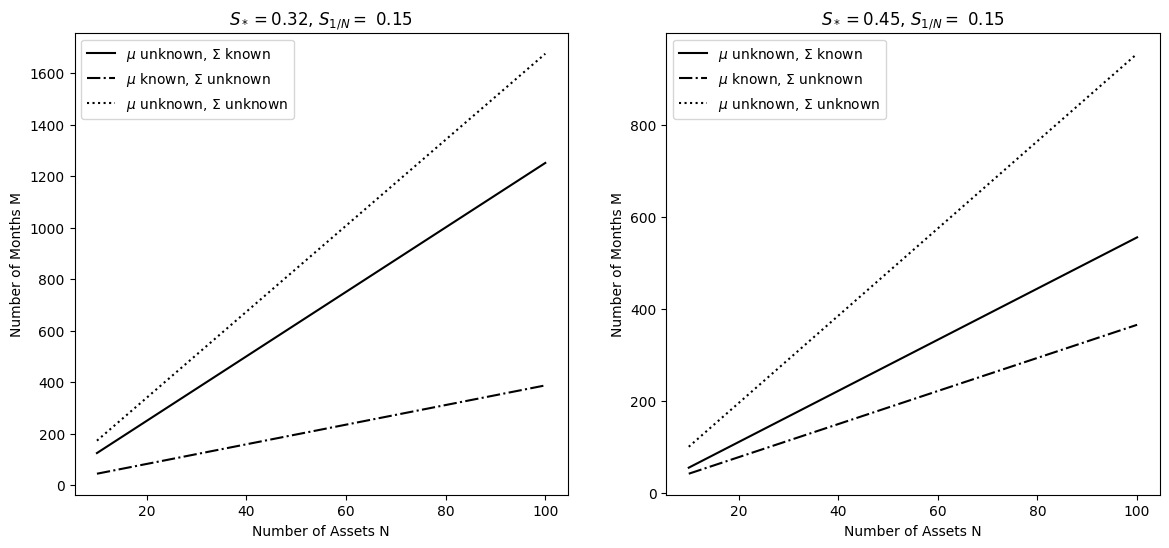

In [ ]:
S_mv1 = 0.32
S_ew1 = 0.15
Ns = np.arange(10, 101, 10)
M1s = [N/(S_mv1**2 - S_ew1**2) for N in Ns]
M2s, M3s = [], []

def objective2(x, N, S_ew, S_mv):
    return (x/(x-N-2))*(2-(x*(x-2))/((x-N-1)*(x-N-4))) - (S_ew/S_mv)**2
def objective3(x, N, S_ew, S_mv):
    k = (x/(x-N-2))*(2-(x*(x-2))/((x-N-1)*(x-N-4)))
    h = N*x*(x-2)/((x-N-1)*(x-N-2)*(x-N-4))
    return k*S_mv**2 - S_ew**2 - h

for N in Ns:
    result2 = fsolve(objective2, 200, args=(N, S_ew1, S_mv1))
    M2s.append(result2[0])
    result3 = fsolve(objective3, 200, args=(N, S_ew1, S_mv1))
    M3s.append(result3[0])

plt.plot(Ns, M1s, c='k', linestyle='-', label='$\mu$ unknown, $\Sigma$ known')
plt.plot(Ns, M2s, c='k', linestyle='-.', label='$\mu$ known, $\Sigma$ unknown')
plt.plot(Ns, M3s, c='k', linestyle=':', label='$\mu$ unknown, $\Sigma$ unknown')
plt.legend()
plt.title('$S_* = $' + str(S_mv) + ', $S_{1/N} =$ ' + str(S_ew))
plt.ylabel('Number of Months M')
plt.xlabel('Number of Assets N')
plt.savefig('WindowLength1.eps', format='eps')
plt.close()


S_mv2 = 0.45
S_ew2 = 0.15
M4s = [N/(S_mv2**2 - S_ew2**2) for N in Ns]
M5s, M6s = [], []
for N in Ns:
    result5 = fsolve(objective2, 200, args=(N, S_ew2, S_mv2))
    M5s.append(result5[0])
    result6 = fsolve(objective3, 200, args=(N, S_ew2, S_mv2))
    M6s.append(result6[0])

plt.plot(Ns, M4s, c='k', linestyle='-', label='$\mu$ unknown, $\Sigma$ known')
plt.plot(Ns, M5s, c='k', linestyle='-.', label='$\mu$ known, $\Sigma$ unknown')
plt.plot(Ns, M6s, c='k', linestyle=':', label='$\mu$ unknown, $\Sigma$ unknown')
plt.legend()
plt.title('$S_* = $' + str(S_mv) + ', $S_{1/N} =$ ' + str(S_ew))
plt.ylabel('Number of Months M')
plt.xlabel('Number of Assets N')
plt.savefig('WindowLength2.eps', format='eps')
plt.close()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axs[0].plot(Ns, M1s, c='k', linestyle='-', label='$\mu$ unknown, $\Sigma$ known')
axs[0].plot(Ns, M2s, c='k', linestyle='-.', label='$\mu$ known, $\Sigma$ unknown')
axs[0].plot(Ns, M3s, c='k', linestyle=':', label='$\mu$ unknown, $\Sigma$ unknown')
axs[0].legend()
axs[0].set_title('$S_* = $' + str(S_mv1) + ', $S_{1/N} =$ ' + str(S_ew1))
axs[0].set_ylabel('Number of Months M')
axs[0].set_xlabel('Number of Assets N')
axs[1].plot(Ns, M4s, c='k', linestyle='-', label='$\mu$ unknown, $\Sigma$ known')
axs[1].plot(Ns, M5s, c='k', linestyle='-.', label='$\mu$ known, $\Sigma$ unknown')
axs[1].plot(Ns, M6s, c='k', linestyle=':', label='$\mu$ unknown, $\Sigma$ unknown')
axs[1].legend()
axs[1].set_title('$S_* = $' + str(S_mv2) + ', $S_{1/N} =$ ' + str(S_ew2))
axs[1].set_ylabel('Number of Months M')
axs[1].set_xlabel('Number of Assets N');